In [1]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
skip_training = True  # Flag to skip training cell if interested only in plotting saved learning curves
cross_type = "out2in" # in2out, out2in
dst_path = "./dataset" # dataset dir previously downloaded
log_dir = "logs" # learning curve dir
ckpt_dir = "checkpoints" # best saved model

In [3]:
# Model translated from CSINet original repository

img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels

class ResidualBlockDecoded(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(2)
        self.act   = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        shortcut = x
        y = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        y = self.act(shortcut + y)
        return y

class CsiNet(nn.Module):
    def __init__(self, encoded_dim=512, residual_num=2):
        super().__init__()
        self.encoded_dim = encoded_dim
        self.residual_num = residual_num

        # first conv
        self.conv_in = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.bn_in   = nn.BatchNorm2d(2)
        self.act     = nn.LeakyReLU(inplace=True)

        # encoder dense
        self.fc_enc  = nn.Linear(img_total, encoded_dim)

        # decoder dense
        self.fc_dec  = nn.Linear(encoded_dim, img_total)

        # residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlockDecoded() for _ in range(residual_num)])

        # final conv + sigmoid
        self.conv_out = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, x):
        # x: (B, 2, 32, 32)
        x = self.act(self.bn_in(self.conv_in(x)))
        # flatten
        B = x.size(0)
        x = x.view(B, -1)              # (B, img_total)
        encoded = self.fc_enc(x)       # (B, encoded_dim)

        x = self.fc_dec(encoded)       # (B, img_total)
        x = x.view(B, img_channels, img_height, img_width)
        for block in self.res_blocks:
            x = block(x)

        x = self.sigmoid(self.conv_out(x))  # (B, 2, 32, 32), in [0,1]
        return x, encoded  # return encoded if you want bottleneck too


In [4]:
dataset_list = os.listdir(dst_path)
dataset_list

['DATA_HtestFin_all.mat',
 'DATA_HtestFout_all.mat',
 'DATA_Htestin.mat',
 'DATA_Htestout.mat',
 'DATA_Htrainin.mat',
 'DATA_Htrainout.mat',
 'DATA_Hvalin.mat',
 'DATA_Hvalout.mat']

In [5]:
# Load datasets

# Load indoor dataset
H_train_in   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainin.mat"))["HT"]
H_val_in     = sio.loadmat(os.path.join(dst_path, "DATA_Hvalin.mat"))["HT"]
H_test_in    = sio.loadmat(os.path.join(dst_path, "DATA_Htestin.mat"))["HT"]

# Load outdoor dataset
H_train_out   = sio.loadmat(os.path.join(dst_path, "DATA_Htrainout.mat"))["HT"]
H_val_out    = sio.loadmat(os.path.join(dst_path, "DATA_Hvalout.mat"))["HT"]
H_test_out    = sio.loadmat(os.path.join(dst_path, "DATA_Htestout.mat"))["HT"]
    
IMG_C, IMG_H, IMG_W = 2, 32, 32   # (channels, delay, angle/antenna)

H_train_in = H_train_in.reshape(-1, IMG_C, IMG_H, IMG_W)
H_val_in = H_val_in.reshape(-1, IMG_C, IMG_H, IMG_W)
H_test_in = H_test_in.reshape(-1, IMG_C, IMG_H, IMG_W)

H_train_out = H_train_out.reshape(-1, IMG_C, IMG_H, IMG_W)
H_val_out = H_val_out.reshape(-1, IMG_C, IMG_H, IMG_W)
H_test_out = H_test_out.reshape(-1, IMG_C, IMG_H, IMG_W)

In [ ]:
if not skip_training:
    # ========================================================
    # Replay Fine-Tuning: Indoor → Outdoor / Outdoor → Indoor
    # ========================================================
    
    # cross_type should be either "in2out" or "out2in"
    #   "in2out": start from indoor model, adapt to outdoor (indoor replay)
    #   "out2in": start from outdoor model, adapt to indoor (outdoor replay)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    replay_ckpt_path = os.path.join(ckpt_dir, "csinet_best_replay_" + cross_type + ".pt")
    
    # ---- Load base model depending on direction ----
    model = CsiNet(encoded_dim=512, residual_num=2).to(device)
    
    if cross_type == "in2out":
        base_name   = "indoor"
        target_name = "outdoor"   # main / new domain we adapt to
        checkpoint  = torch.load(os.path.join(ckpt_dir, "csinet_best_indoor.pt"),
                                 map_location=device)
    elif cross_type == "out2in":
        base_name   = "outdoor"
        target_name = "indoor"
        checkpoint  = torch.load(os.path.join(ckpt_dir, "csinet_best_outdoor.pt"),
                                 map_location=device)
    else:
        raise ValueError(f"Unknown cross_type: {cross_type}")
    
    model.load_state_dict(checkpoint["model_state_dict"])
    
    print(f"Loaded {base_name} base model from epoch {checkpoint['epoch']} "
          f"with val_loss={checkpoint['val_loss']:.4e}")
    
    # ---- Prepare tensors (KEEP ON CPU) ----
    # NOTE: do NOT .to(device) here – datasets stay on CPU
    x_train_in_t   = torch.from_numpy(H_train_in).float()
    x_val_in_t     = torch.from_numpy(H_val_in).float()
    x_train_out_t  = torch.from_numpy(H_train_out).float()
    x_val_out_t    = torch.from_numpy(H_val_out).float()
    
    # ---- Choose which is target (main) and which is replay ----
    if cross_type == "in2out":
        # main = outdoor, replay = indoor
        x_train_main   = x_train_out_t
        x_val_main     = x_val_out_t
        x_train_replay = x_train_in_t
        x_val_replay   = x_val_in_t
        main_label     = "outdoor"
        replay_label   = "indoor"
    else:  # "out2in"
        # main = indoor, replay = outdoor
        x_train_main   = x_train_in_t
        x_val_main     = x_val_in_t
        x_train_replay = x_train_out_t
        x_val_replay   = x_val_out_t
        main_label     = "indoor"
        replay_label   = "outdoor"

# ========================================================
# LIMIT REPLAY MEMORY TO A RANDOM SUBSET OF THE SOURCE
# ========================================================
memory_size = 10000  # choose buffer size here

N = x_train_replay.shape[0]
if memory_size < N:
    perm = torch.randperm(N)[:memory_size]
    x_train_replay = x_train_replay[perm]

print(f"Replay subset selected: {x_train_replay.shape[0]} samples (was {N})")
# ========================================================
    
    # Loader over MAIN (target) domain – still CPU tensors here
    batch_size_main = 200
    train_loader_main = DataLoader(
        TensorDataset(x_train_main, x_train_main),
        batch_size=batch_size_main,
        shuffle=True
    )
    
    N_replay_train = x_train_replay.shape[0]
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # smaller LR for fine-tune
    criterion = nn.MSELoss()
    
    epochs   = 100
    patience = 10
    replay_ratio = 0.25  # 25% weight for replay loss
    
    best_val_main = float("inf")
    patience_ctr = 0
    
    train_losses_replay    = []
    val_losses_main_replay = []
    val_losses_rep_replay  = []
    
    for epoch in range(epochs):
        # ---- TRAIN (main domain + replay domain) ----
        model.train()
        train_loss = 0.0
        total_samples = 0
    
        for xb_main, yb_main in train_loader_main:
            B = xb_main.size(0)
    
            # move main batch to GPU
            xb_main = xb_main.to(device, non_blocking=True)
            yb_main = yb_main.to(device, non_blocking=True)
    
            # Sample replay indices ON CPU, then move replay batch to GPU
            idx_rep = torch.randint(0, N_replay_train, (B,), device="cpu")
            xb_rep  = x_train_replay[idx_rep].to(device, non_blocking=True)
    
            optimizer.zero_grad()
    
            # Main (target) forward
            y_hat_main, _ = model(xb_main)
            loss_main = criterion(y_hat_main, yb_main)
    
            # Replay forward
            y_hat_rep, _ = model(xb_rep)
            loss_rep = criterion(y_hat_rep, xb_rep)
    
            # Total loss: main + replay_ratio * replay
            loss = loss_main + replay_ratio * loss_rep
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item() * B
            total_samples += B
    
        train_loss /= total_samples
    
        # ---- VALIDATION: track both main & replay domains ----
        model.eval()
        with torch.no_grad():
            # move validation sets to GPU JUST for this step
            x_val_main_gpu   = x_val_main.to(device, non_blocking=True)
            x_val_replay_gpu = x_val_replay.to(device, non_blocking=True)
    
            # main val
            y_hat_val_main, _ = model(x_val_main_gpu)
            val_loss_main = criterion(y_hat_val_main, x_val_main_gpu).item()
    
            # replay val
            y_hat_val_rep, _ = model(x_val_replay_gpu)
            val_loss_rep = criterion(y_hat_val_rep, x_val_replay_gpu).item()
    
        train_losses_replay.append(train_loss)
        val_losses_main_replay.append(val_loss_main)
        val_losses_rep_replay.append(val_loss_rep)
    
        print(f"[Replay {base_name}→{target_name}] Epoch {epoch:03d} | "
              f"train={train_loss:.4e} | "
              f"val_{main_label}={val_loss_main:.4e} | "
              f"val_{replay_label}={val_loss_rep:.4e}")
    
        # ---- EARLY STOPPING on MAIN (target) val loss ----
        if val_loss_main < best_val_main - 1e-6:
            best_val_main = val_loss_main
            patience_ctr = 0
    
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss_main': val_loss_main,
                'val_loss_replay': val_loss_rep,
                'main_label': main_label,
                'replay_label': replay_label,
                'cross_type': cross_type
            }, replay_ckpt_path)
    
            print(f"  --> New best replay model saved to {replay_ckpt_path} "
                  f"(val_{main_label}={val_loss_main:.4e}, "
                  f"val_{replay_label}={val_loss_rep:.4e})")
        else:
            patience_ctr += 1
            print(f"  No improvement for {patience_ctr}/{patience} epochs")
    
            if patience_ctr >= patience:
                print("Early stopping (replay fine-tuning) triggered.")
                break
    
    print(f"Replay fine-tuning finished. Best {main_label} val_loss={best_val_main:.4e}")
    
    # Saving learning curves for plots
    np.save(os.path.join(log_dir, "train_losses_replay_" + cross_type + ".npy"),
            np.array(train_losses_replay))
    np.save(os.path.join(log_dir, "val_losses_main_replay_" + cross_type + ".npy"),
            np.array(val_losses_main_replay))
    np.save(os.path.join(log_dir, "val_losses_rep_replay_" + cross_type + ".npy"),
            np.array(val_losses_rep_replay))


[Replay out2in] Best indoor val loss = 6.6322e-05 at epoch 56
[Replay out2in] outdoor val loss at that epoch = 1.7841e-04
[Replay out2in] Final train loss = 7.1257e-05
[Replay out2in] Final indoor val loss   = 1.0639e-04
[Replay out2in] Final outdoor val loss = 1.6007e-04


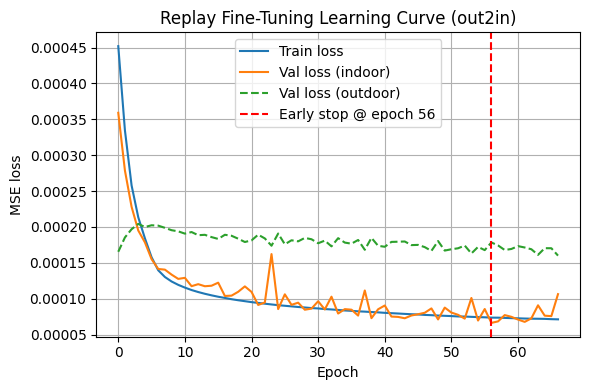

In [7]:
# ======================================
# Learning curve for REPLAY fine-tuning
# ======================================

# Example: cross_type = "in2out" or "out2in"
# Must match what used in training cell
replay_ckpt_path = os.path.join(ckpt_dir, "csinet_best_replay_" + cross_type + ".pt")

train_losses_replay = np.load(os.path.join(log_dir, "train_losses_replay_" + cross_type + ".npy"))
val_main_replay     = np.load(os.path.join(log_dir, "val_losses_main_replay_" + cross_type + ".npy"))
val_rep_replay      = np.load(os.path.join(log_dir, "val_losses_rep_replay_" + cross_type + ".npy"))

# Load early stopping epoch from replay checkpoint
replay_ckpt = torch.load(replay_ckpt_path, map_location='cpu')
best_epoch_replay = replay_ckpt['epoch']
main_label   = replay_ckpt.get('main_label',  'main')
replay_label = replay_ckpt.get('replay_label','replay')

best_val_main = val_main_replay[best_epoch_replay]
best_val_rep  = val_rep_replay[best_epoch_replay]

print(f"[Replay {cross_type}] Best {main_label} val loss = {best_val_main:.4e} at epoch {best_epoch_replay}")
print(f"[Replay {cross_type}] {replay_label} val loss at that epoch = {best_val_rep:.4e}")
print(f"[Replay {cross_type}] Final train loss = {train_losses_replay[-1]:.4e}")
print(f"[Replay {cross_type}] Final {main_label} val loss   = {val_main_replay[-1]:.4e}")
print(f"[Replay {cross_type}] Final {replay_label} val loss = {val_rep_replay[-1]:.4e}")

# Plot learning curves
plt.figure(figsize=(6,4))
plt.plot(train_losses_replay, label="Train loss")
plt.plot(val_main_replay, label=f"Val loss ({main_label})")
plt.plot(val_rep_replay,  label=f"Val loss ({replay_label})", linestyle="--")

# Vertical line for early stopping
plt.axvline(best_epoch_replay, color='red', linestyle='--', linewidth=1.5,
            label=f"Early stop @ epoch {best_epoch_replay}")

plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Replay Fine-Tuning Learning Curve (" + cross_type + ")")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(os.path.join(log_dir, "learning_curve_replay_" + cross_type + ".png"))
plt.show()
